# Probabilistic Modelling using the Infinite Mixture Model

In [2]:
using Turing

In many applications it is desirable to allow the model to adjust its complexity according to the complexity of the data. Consider for example the task of grouping objects into clusters / groups. This task often involves the specification of the number of groups. However, in real world applications it is often not known a prior how many groups are to be expected. Further, the number of examples per group often is heavy tailed, making it necessary to allow the model to form new groups when new data points are observed.

A natural approach for such applications is the use of non-parametric models. This tutorial will introduce how to use the Dirichlet process to model a mixture of infinitely many groups in Turing. For further information on Bayesian nonparametrics and the Dirichlet process we refer to the [introduction by Zoubin Ghahramani](http://mlg.eng.cam.ac.uk/pub/pdf/Gha12.pdf) and the book "Fundamentals of Nonparametric Bayesian Inference" by Subhashis Ghosal and Aad van der Vaart.

## Mixture Model

Before introducting how to learn infinite mixture models in Turing, we will briefly review the construction of finite mixture models. Subsequently, we will define what a Dirichlet process is and show how to use the "Chinese restaurant process" construction for non-parametric clustering of observations.

#### Two-Component Model

First, consider the simple case of a mixture model with two Gaussian components with fixed covariance. 
The generative procvess of such a model can be written as:

$$ (\pi_1, \pi_2) \sim Beta(a, b) $$
$$ \mu_1 \sim Normal(\mu_0, \Sigma_0) $$
$$ \mu_2 \sim Normal(\mu_0, \Sigma_0) $$
$$ z \sim Categorical(\pi_1, \pi_2) $$
$$ x \sim Normal(\mu_z, \Sigma) $$

If we would implement this model in Turing for 1D data we would write:

In [5]:
@model two_model(x; a=1, b=1, μ0=0.0, σ0=1.0) = begin
    
    # Draw weights.
    π1 ~ Beta(a,b)
    π2 = 1-π1
    
    # Draw locations of the components.
    μ1 ~ Normal(μ0, σ0)
    μ2 ~ Normal(μ0, σ0)
    
    # Draw latent assignment.
    z ~ Categorical([π1, π2])
    
    # Draw observation from selected component.
    if z == 1
        x ~ Normal(μ1, 1.0)
    else
        x ~ Normal(μ2, 1.0)
    end
end

two_model (generic function with 2 methods)

#### Finite Mixture Model

If we have more than one component we can elegantly extend this model by using a Dirichlet distribution as prior for the weights $\pi_1, \dots, \pi_K$ as the Dirichlet distribution is the multivariate generalization of the beta distribution. The resulting model then can be written as:

$$ (\pi_1, \dots, \pi_K) \sim Dirichlet(K, \alpha) $$
$$ \mu_k \sim Normal(\mu_0, \Sigma_0), \;\; \forall k$$
$$ z \sim Categorical(\pi_1, \dots, \pi_K) $$
$$ x \sim Normal(\mu_z, \Sigma) $$

which resembles the model in the [Gaussian mixture model tutorial](1_GaussianMixtureModel.ipynb) with a slightly different notation.

## Infinite Mixture Model (Dirichlet process)

The question now arises, is there a generalization of a Dirichlet distribution for which the dimensionality $K$ is infinite, i.e. $K = \infty$? And if so, how would we use / learn such a model as it would require us to represent and store infinitely many weights and parameters, which is obviously not possible.

In [ ]:
One way to 

#### Chinese Restaurant Process

In [1]:
using Turing, Turing.RandomMeasures, Plots, Random

In [75]:
# Number of observations.
Ns = [10^2, 5*10^2, 10^3, 5*10^3, 10^4]

# Concentration parameters of the Dirichlet process.
αs = [1.0, 10.0, 30.0]

# Number of re-runs to get stable estimates.
R = 4

# Output.
K = zeros(length(Ns), length(αs))

for (j, α) in enumerate(αs)
    
    # Construct a Dirichlet process with concentration α.
    rpm = DirichletProcess(α)
    for (i, N) in enumerate(Ns)
        Random.seed!(1)
        for r in 1:R
            
            # Number of observations per cluster.
            m = Vector{Int}()
            for n in 1:N
                
                # Sample assignment for each observation using a ChineseRestaurantProcess.
                z = rand(ChineseRestaurantProcess(rpm, m))
                if z > length(m)
                    
                    # Assignment to a new cluster.
                    append!(m, [1])
                else
                    
                    # Assignment to an existing cluster.
                    m[z] += 1
                end
            end
            K[i,j] += length(m)
        end
        K[i,j] /= R
    end
end

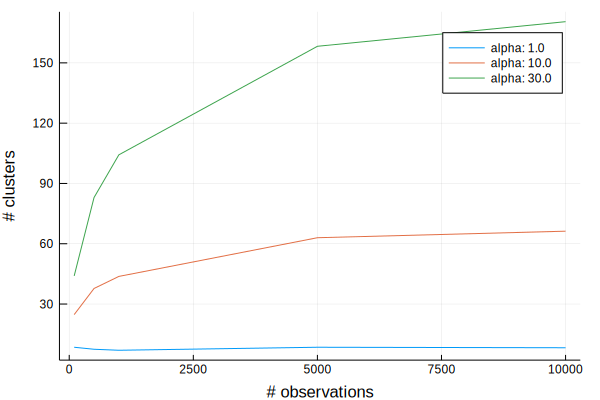

In [76]:
plot(Ns, K, labels = map(α -> "alpha: $α", αs), 
    xlabel = "# observations", ylabel = "# clusters")